## **0. Setup**

In [38]:
import os, glob, warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.multicomp import pairwise_tukeyhsd

# ignore warnings
warnings.filterwarnings('ignore')

# plotting configuration
font = {'family': 'Arial', 'size': 15}
mpl.rc('font', **font)
plt.rcParams['svg.fonttype'] = 'none'

# my_pal = ['grey', 'mediumseagreen']
my_pal = ['grey', 'mediumseagreen', 'dodgerblue', 'darkviolet', 'yellow']

# Make a folder if it not there yet and if needed
# !mkdir ../jupyter_figures

# set the directory where the data files are waiting
# directory = '/Users/ShokenLEE/Desktop/DATA/Common data spreadsheets/nLD/RNAi/'
directory = '/Users/ShokenLEE/Desktop/DATA/2022 10-12/P-235 Sun2 OE nLD/done'

In [2]:
micron_per_pixel = 0.23

## **1. Concanatate all the CSV files**

In [57]:
df = pd.DataFrame() # for nuclear protein and DAPI intensity data
df_LD = pd.DataFrame() # for LD data

for path, subdirs, files in os.walk(directory):
    for file in files:
        if (file.endswith('csv')) & ('ROI' not in file):
            _df = pd.read_csv(os.path.join(path, file))
            df = pd.concat([df, _df], axis=0)
        elif (file.endswith('csv')) & ('ROI' in file):
            _df = pd.read_csv(os.path.join(path, file))
            df_LD = pd.concat([df_LD, _df], axis=0)

In [58]:
# rename columns
df = df.rename(columns={' ': 'ROI_number'})
df_LD = df_LD[[' ', 'Area', 'File name', 'ROI_number']]

In [59]:
df.info()
# df_LD.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 950 entries, 0 to 5
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ROI_number  950 non-null    int64  
 1   Area        950 non-null    float64
 2   Mean        950 non-null    float64
 3   Circ.       950 non-null    float64
 4   AR          950 non-null    float64
 5   Round       950 non-null    float64
 6   Solidity    950 non-null    float64
 7   DAPI mean   950 non-null    float64
 8   File name   950 non-null    object 
dtypes: float64(7), int64(1), object(1)
memory usage: 74.2+ KB


#### Check the number of files

In [60]:
print(len(df['File name'].unique()), len(df_LD['File name'].unique()))

85 85


## **2. Summerize LD data**

In [61]:
# total area and number (count) of LD per nucleus
df_LD_sumArea = df_LD.groupby(['File name', 'ROI_number'], as_index=False)['Area'].sum().rename(columns={'Area': 'total_nLD_area'})
df_LD_count = df_LD.groupby(['File name', 'ROI_number'], as_index=False)['Area'].count().rename(columns={'Area': 'number_of_nLD'})

# Merged the two above to summarize LD data
df_LD_summary = df_LD_count.merge(df_LD_sumArea, on=['File name', 'ROI_number'])

# Merge the LD data above to the df of nuclear protein and DAPI intensity data
df = df.merge(df_LD_summary, how='outer', on=['File name', 'ROI_number'])

# fill NA with 0
df.fillna(0, inplace=True)

In [62]:
df['nLD_area_fraction'] = df.total_nLD_area / df.Area

## **3. Group cell/condition types**

#### **Prepare column order for graphs**

In [63]:
# Pre-define groups (conditions) and its order in graphs
group_name_options = ['siRNA type', 'Plasmid type']
group_name = group_name_options[1]

group_order_options = [
    ['siCtrl', 'siSun2', 'siSun1', 'siCTDNEP1'],
    ['Mock', 'WT', '2SA', '2SA_LVWA', 'Sun1']
]
group_order = group_order_options[1]

hue_name = 'Sun2_OE'
hue_order = ['(-)', '(+)']

#### **Cell type**

In [45]:
df.loc[df['File name'].str.contains('Sctrl'), 'Cell type'] = 'Control'
df.loc[df['File name'].str.contains('CTDNEP1'), 'Cell type'] = 'CTDNEP1 KO'

#### **siRNA type**

In [10]:
df.loc[df['File name'].str.contains('siCtrl'), 'siRNA type'] = group_order[0]
df.loc[df['File name'].str.contains('siSun2'), 'siRNA type'] = group_order[1]
df.loc[df['File name'].str.contains('siSun1'), 'siRNA type'] = group_order[2]
df.loc[df['File name'].str.contains('siCTDNEP1'), 'siRNA type'] = group_order[3]

#### **Plasmid type**

In [64]:
df.loc[df['File name'].str.contains('mock'), 'Plasmid type'] = group_order[0]
df.loc[df['File name'].str.contains('WT '), 'Plasmid type'] = group_order[1]
df.loc[df['File name'].str.contains('SA '), 'Plasmid type'] = group_order[2]
df.loc[df['File name'].str.contains('SA-LVWA'), 'Plasmid type'] = group_order[3]
df.loc[df['File name'].str.contains('Sun1'), 'Plasmid type'] = group_order[4]

#### **Sun2 OE Cutoff**

In [65]:
# Set the threshold
min_tag_intensity = 3000

# Sort Tag mean based on the threshold
df['Sun2_OE'] = df.apply(lambda x: '(+)' if x['Mean'] > min_tag_intensity else '(-)', axis=1)

#### **Image number**

In [66]:
df['Image number'] = df['File name'].str[-7:-4]

##### Check the number is correctly extracted

In [67]:
print(list(df['Image number'].unique())[1])

006


## **4. Analysis**

### **Sample size**

In [68]:
# df.groupby(['siRNA type']).size()
df.groupby([group_name, hue_name]).size()

Plasmid type  Sun2_OE
2SA           (+)         99
              (-)         48
2SA_LVWA      (+)         88
              (-)        136
Mock          (-)        138
Sun1          (+)         49
              (-)        167
WT            (+)         93
              (-)        132
dtype: int64

In [31]:
df[df.number_of_nLD>0].groupby([group_name]).size()

Sun2_OE
(+)    72
(-)    78
dtype: int64

### **Nuclear LD analysis**

### % of cells with nLD

In [69]:
# _df_1: n of total cells; _df_2: n of cells with nLD
_df_1 = df.groupby([group_name], as_index=False).size().rename(columns={'size': 'number_of_cells'})
_df_2 = df[df.number_of_nLD > 0].groupby([group_name], as_index=False).size().rename(columns={'size': 'number_of_cells_w_nLD'})
df_n_cells = _df_1.merge(_df_2, on=[group_name])

df_n_cells['% of cells with nLD'] = df_n_cells.number_of_cells_w_nLD / df_n_cells.number_of_cells * 100
# df_n_cells.to_csv(directory + '/n_of_cells.csv', index_label=False)
df_n_cells

,Plasmid type,number_of_cells,number_of_cells_w_nLD,% of cells with nLD
0,2SA,147,91,61.904762
1,2SA_LVWA,224,130,58.035714
2,Mock,138,78,56.521739
3,Sun1,216,109,50.462963
4,WT,225,152,67.555556


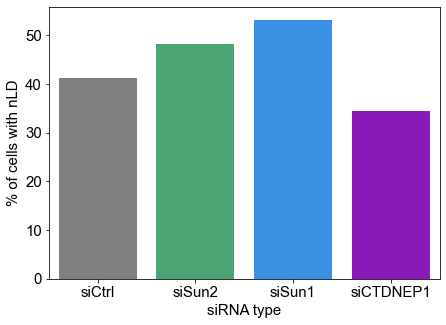

In [18]:
fig = plt.figure(figsize=(7,5))
ax = sns.barplot(data= df_n_cells, x=group_name, y='% of cells with nLD',
                 order=group_order,
                palette=my_pal)
# plt.legend(bbox_to_anchor=(1.05, 1), title='Sun2 OE', loc='upper left', borderaxespad=0)

In [114]:
fig.savefig(directory + '/%cells_w_nLD.pdf', bbox_inches='tight', transparent=True)

### nLD area: mean values

In [34]:
df[df['number_of_nLD']>0].groupby(group_name)['nLD_area_fraction'].mean()

Sun2_OE
(+)    0.008767
(-)    0.013627
Name: nLD_area_fraction, dtype: float64

In [33]:
df[df['number_of_nLD']>0].groupby(group_name)['number_of_nLD'].mean()

Sun2_OE
(+)    2.527778
(-)    3.064103
Name: number_of_nLD, dtype: float64

### Mean area of nLD per cell (not quantifiable with Sun2 OE experiment)

In [36]:
# group siRNA type
df_LD.loc[df_LD['File name'].str.contains('siCtrl'), 'siRNA type'] = column_order[0]
df_LD.loc[df_LD['File name'].str.contains('siSun2'), 'siRNA type'] = column_order[1]
df_LD.loc[df_LD['File name'].str.contains('siSun1'), 'siRNA type'] = column_order[2]
df_LD.loc[df_LD['File name'].str.contains('siSeipin'), 'siRNA type'] = column_order[3]
df_LD.loc[df_LD['File name'].str.contains('siCTDNEP1'), 'siRNA type'] = column_order[4]

# convert pixel sq to micron sq
df_LD['Area_micronsq'] = df_LD.Area * np.square(0.23)

fig = plt.figure(figsize=(7,6))
ax1 = sns.boxplot(data=df_LD[df_LD['Area_micronsq']<2], x=group_name, y='Area_micronsq', 
                  order=column_order, palette=my_pal)
plt.title('Area of indivisual nLD')
plt.ylabel('Area (square micron)')

In [72]:
df_LD.groupby(['siRNA type'])['Area_micronsq'].mean()

siRNA type
siCTDNEP1    0.039249
siCtrl       0.042030
siSeipin     0.042515
siSun1       0.051057
siSun2       0.050856
Name: Area_micronsq, dtype: float64

In [75]:
df_LD.groupby(['siRNA type']).size()

siRNA type
siCTDNEP1    101
siCtrl       150
siSeipin     205
siSun1       272
siSun2       201
dtype: int64

In [69]:
fig.savefig(directory + '/Area_individual_nLD.pdf', bbox_inches='tight', transparent=True)

### Graphs of nLD area and number

Text(0, 0.5, 'Area_fraction')

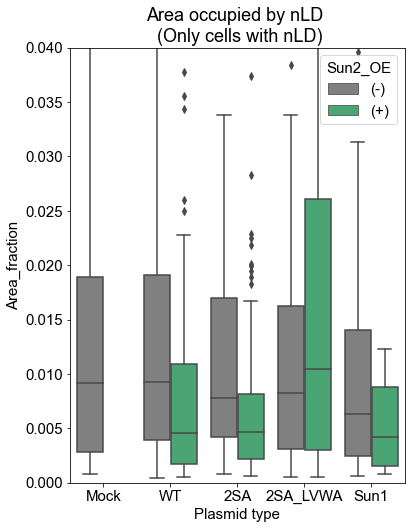

In [70]:
# fig, ax = plt.subplots(1, 3, figsize=(15, 5))

fig = plt.figure(figsize=(6,8))
# ax_box = fig.add_axes([0.1, 0.1, 0.8, 0.8])

# ax1 = fig.add_subplot(2,2,1)
# ax1 = sns.boxplot(data=df, x=group_name, order=group_order, y='nLD_area_fraction', palette=my_pal)
# plt.title('Area occupied by nLD \n (All cells)')
# plt.ylabel('Area_fraction')
# # plt.legend(bbox_to_anchor=(1.05, 1), title='Sun2 OE', loc='upper left', borderaxespad=0)
# # plt.yscale('log')
# # ax1.spines['top'].set_visible(False)
# # ax_box.spines['right'].set_visible(False)

ax2 = fig.add_subplot(1,1,1)
ax2 = sns.boxplot(data=df[df.number_of_nLD > 0], x=group_name, order=group_order, hue=hue_name, hue_order=hue_order, y='nLD_area_fraction', palette=my_pal)
plt.ylim([0, 0.04])
plt.title('Area occupied by nLD \n (Only cells with nLD)')
plt.ylabel('Area_fraction')

# ax3 = fig.add_subplot(2,2,2)
# ax3 = sns.boxplot(data=df[df.number_of_nLD > 0], x=group_name, order=group_order, y='nLD_area_fraction', palette=my_pal)
# plt.ylim([0.04, 0.1])
# plt.title('Area occupied by nLD \n (Only cells with nLD)')
# plt.ylabel('Area_fraction')

# ax3 = fig.add_subplot(2,2,3)
# ax3 = sns.boxplot(data=df, x=group_name, order=group_order, y='number_of_nLD', palette=my_pal)
# plt.title('Number of nLD per nucleus \n (All cells)')
# plt.ylabel('Count')
# # plt.yscale('log')

# ax3 = fig.add_subplot(2,2,4)
# ax3 = sns.boxplot(data=df[df.number_of_nLD > 0], x=group_name, order=group_order, y='number_of_nLD', palette=my_pal)
# plt.title('Number of nLD per nucleus \n (Only cells with nLD)')
# plt.ylabel('Count')
# # # plt.yscale('log')

In [39]:
fig.savefig(directory + '/nLD_area_number_bottom.pdf', bbox_inches='tight', transparent=True)

Text(0, 0.5, 'Area_fraction')

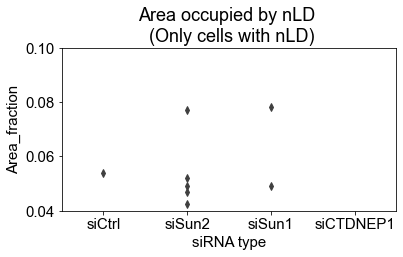

In [40]:
fig = plt.figure(figsize=(6,3))
ax3 = fig.add_subplot(1,1,1)
ax3 = sns.boxplot(data=df[df.number_of_nLD > 0], x=group_name, order=group_order, y='nLD_area_fraction', palette=my_pal)
plt.ylim([0.04, 0.1])
plt.title('Area occupied by nLD \n (Only cells with nLD)')
plt.ylabel('Area_fraction')

In [41]:
fig.savefig(directory + '/nLD_area_number_top.pdf', bbox_inches='tight', transparent=True)

### **Tukey test**

### With non-nLD cells

In [20]:
res = pairwise_tukeyhsd(df['nLD_area_fraction'], df["Sun2_OE"], alpha=0.05)
print(res)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   (+)    (-)   0.0016 0.3673 -0.0019 0.0051  False
---------------------------------------------------


### Without non-nLD cells

In [20]:
_df = df[df['number_of_nLD'] > 0]
res = pairwise_tukeyhsd(_df['nLD_area_fraction'], _df['siRNA type'], alpha=0.05)
print(res)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
  group1  group2 meandiff p-adj   lower  upper  reject
------------------------------------------------------
siCTDNEP1 siCtrl   0.0003    0.9 -0.0038 0.0043  False
siCTDNEP1 siSun2   0.0026 0.2955 -0.0015 0.0067  False
   siCtrl siSun2   0.0023  0.293 -0.0013  0.006  False
------------------------------------------------------


#### **C3 channel intensity (background subtracted)**

##### **C3 distribution**

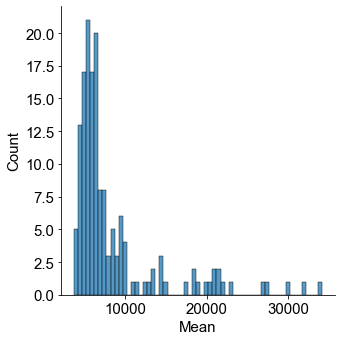

In [7]:
hist = sns.displot(x='Mean', data=df, binwidth=500)
# hist = sns.displot(x='Mean', data=df, col='Cell type', hue='siRNA type', hue_order=['siCtrl', 'siCDS1', 'siCDS2', 'siPIS'], palette=my_pal, binwidth=500)

In [49]:
# df.groupby('Tag expression')['Mean'].min()
df['Mean'].min()

3180.545

##### **Background subtraction from C3 intensity value**

In [8]:
background_C3 = 1800

df['C3 mean - background'] = df['Mean'] - background_C3

#### **Scatter plot (nLD area vs Sun2 intensity)**

<Figure size 360x360 with 0 Axes>

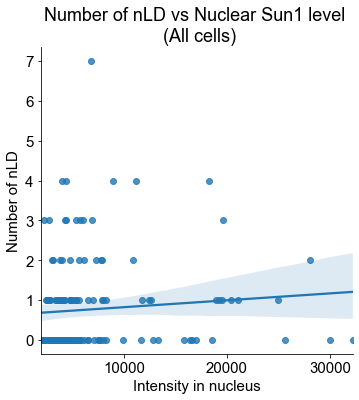

In [11]:
fig = plt.figure(figsize=(5, 5))
scatter = sns.lmplot(x='C3 mean - background', y='number_of_nLD', data=df, legend_out=False)
plt.title('Number of nLD vs Nuclear Sun1 level \n (All cells)')
plt.xlabel('Intensity in nucleus')
plt.ylabel('Number of nLD')
scatter.savefig(directory + '/N_of_LD_vs_Sun1_all_cells.jpg', bbox_inches='tight')

<Figure size 720x720 with 0 Axes>

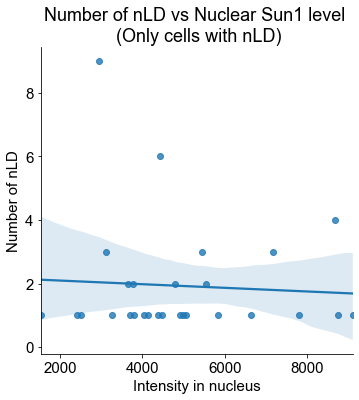

In [53]:
fig = plt.figure(figsize=(10,10))
scatter = sns.lmplot(x='C3 mean - background', y='number_of_nLD', data=df[df.number_of_nLD > 0], legend_out=False)
plt.title('Number of nLD vs Nuclear Sun1 level \n (Only cells with nLD)')
plt.xlabel('Intensity in nucleus')
plt.ylabel('Number of nLD')
scatter.savefig(directory + '/N_of_LD_vs_Sun1_nLD_cells.jpg', bbox_inches='tight')

<Figure size 720x720 with 0 Axes>

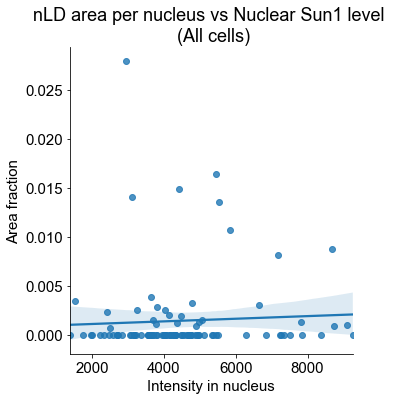

In [55]:
fig = plt.figure(figsize=(10,10))
scatter = sns.lmplot(x='C3 mean - background', y='nLD_area_fraction', data=df, legend_out=False)
plt.title('nLD area per nucleus vs Nuclear Sun1 level \n (All cells)')
plt.xlabel('Intensity in nucleus')
plt.ylabel('Area fraction')
scatter.savefig(directory + '/Area_of_LD_vs_Sun2_all_cells.jpg', bbox_inches='tight')

<Figure size 720x720 with 0 Axes>

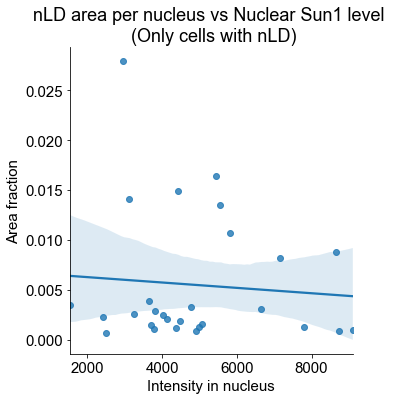

In [56]:
fig = plt.figure(figsize=(10,10))
scatter = sns.lmplot(x='C3 mean - background', y='nLD_area_fraction', data=df[df.number_of_nLD > 0], legend_out=False)
plt.title('nLD area per nucleus vs Nuclear Sun1 level \n (Only cells with nLD)')
plt.xlabel('Intensity in nucleus')
plt.ylabel('Area fraction')
scatter.savefig(directory + '/Area_of_LD_vs_Sun1_nLD_cells.jpg', bbox_inches='tight')

In [98]:
fig.savefig(directory + '/N_of_LD_vs_Sun2_nLD_cells.pdf', transparent=True, bbox_inches='tight')

#### **3-1. Mitotic cells**

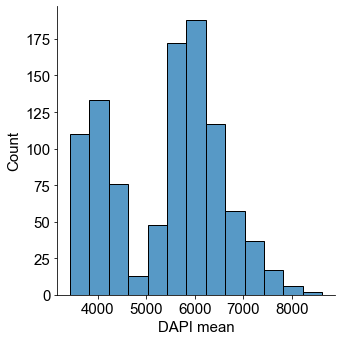

In [14]:
# hist = sns.displot(data=df, x='DAPI mean', hue='Cell type', hue_order=['Control', 'CTDNEP1 KO'], binwidth=400)
hist = sns.displot(data=df, x='DAPI mean', binwidth=400)
# plt.xlim([1000,4000])

#### **Remove cells with too hight DAPI intensity, which are likely mitotic cells**

In [32]:
max_DNA_intensity = 12000

df = df[df['DAPI mean'] < max_DNA_intensity]